# **<span style="color:red">Solutions 1</span>**

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [1]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'

# KEY_CALLABLE = 'FHLMC 1 1/4 01/29/30'
# KEY_CALLABLE = 'FHLMC 0.97 01/28/28'

# FILE_BOND = '../data/callable_bonds_2025-02-18.xlsx'
# FILE_CURVE = '../data/discount_curve_2025-02-18.xlsx'
# KEY_CALLABLE = 'FHLMC 4.55 02/11/28'

### Bond Info

In [2]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [3]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [4]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

Also calculate the price of the `hypothetical` bonds, where we consider a non-callable version of the callable bond with 
* maturity unchanged
* maturity at the call date.

### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# **<span style="color:red">Solution 1</span>**

In [5]:
import sys
sys.path.insert(0, '../cmds')
from fiderivs import *

In [6]:
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [7]:
DAYS_YEAR = 365.25
FACE = 100

quotes.loc['TTC'] = (pd.to_datetime(info.loc['Date Next Call']) - pd.to_datetime(info.loc['Date Quoted'])).dt.days / DAYS_YEAR

#### Modifications on Time-to-Expiration

Modify the time-to-expiration if evaluating the reference bonds to align expiration with coupon date.

In [8]:
if quotes.loc['TTC',KEY_CALLABLE] < 0.3:
    quotes.loc['TTC',KEY_CALLABLE] += .25

In order to see the negative convexity stronger, try setting the key bond's time-to-expiration to one year.

In [9]:
MODIFY_EXPRY = False

if MODIFY_EXPRY:
    quotes.loc['TTC'] = 1

In [10]:
DISC_INTERVAL = 0.1

Tmaturity = quotes.loc['TTM',KEY_CALLABLE]
Topt = quotes.loc['TTC',KEY_CALLABLE]
cpnfreq = info.loc['Cpn Freq', KEY_CALLABLE]

time_to_cpn = round(Tmaturity % (1 / cpnfreq), 2)
discs = interpolate_curve(discs[['maturity date','discount']].rename(columns={'maturity date':'date'}),interval_years=DISC_INTERVAL,compounding=2,anchor_ttm=Topt,min_ttm=0.05)

discount_grid_step = (discs.index[1]-discs.index[0])
grid_step_cpn = round(1 / (cpnfreq * discount_grid_step))

### **<span style="color:red">1.1. Bond Pricing</span>**

In [11]:
prices = pd.DataFrame(dtype=float,index=['hypothetical T1', 'hypothetical T2', 'callable'],columns=['model','market'])

T1 = quotes.loc['TTC',KEY_CALLABLE]
T2 = quotes.loc['TTM',KEY_CALLABLE]
accint = quotes.loc['Accrued Interest',KEY_CALLABLE]
cpnrate = info.loc['Cpn Rate',KEY_CALLABLE]

prices.loc['hypothetical T1','model'] = price_bond(discs,cpnrate=cpnrate,ttm=T1)
prices.loc['hypothetical T1','model'] += accint

prices.loc['hypothetical T2','model'] = price_bond(discs,cpnrate=cpnrate,ttm=T2)
prices.loc['hypothetical T2','model'] += accint

prices.loc['callable','market'] = quotes.loc['Dirty Price',KEY_CALLABLE]
prices.style.format('{:.2f}',na_rep='')

,model,market
hypothetical T1,101.08,
hypothetical T2,101.57,
callable,,100.09


### **<span style="color:red">1.2. Forward Pricing</span>**

In [12]:
Pspot = prices.loc['hypothetical T2','model']

Pfwd = calc_forward_bond_price(Pspot,Topt,discs,cpnrate,face=FACE)

tab_fwd = pd.DataFrame([Pspot,Pfwd],index=['spot','forward'],columns=['modeled price'])
tab_fwd.index.name = 'hypothetical (un-callable) bond'
tab_fwd.style.format('{:.2f}')

,modeled price
hypothetical (un-callable) bond,
spot,101.57
forward,100.52


We see that the forward price is lower than spot if the coupon rate is higher than the forward rates.

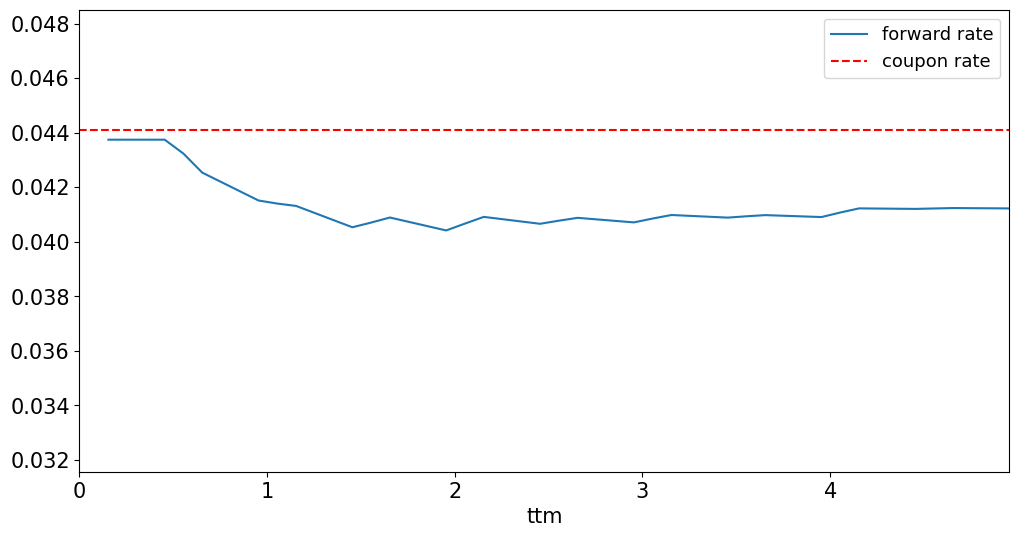

In [13]:
frates = discounts_to_forwardcurve(discs['discount'],n_compound=2)
ax = frates.plot()
ax.axhline(cpnrate, color='r', linestyle='--')
plt.xlim(0,Tmaturity)
plt.ylim(None,np.max([cpnrate,frates.max()])*1.1)
plt.legend(['forward rate','coupon rate'])
plt.show()

### **<span style="color:red">1.3. Implied Vol</span>**

The implied vol of the bond price is approximated via the implied vol of the forward rate.

In [14]:
duration_callable = quotes.loc['Duration',KEY_CALLABLE]
ivol_rate = quotes.loc['Implied Vol',KEY_CALLABLE]/100

Topt_rounded = get_approximate_discount(Topt,discs)
fwdrate = frates.loc[Topt_rounded]   

ivol_price = ratevol_to_pricevol(ivol_rate,fwdrate,duration_callable)

pd.DataFrame([ivol_rate,ivol_price],index=['fwd rate','fwd price'], columns=['implied vol']).style.format('{:.2%}')

,implied vol
fwd rate,23.88%
fwd price,4.37%


### **<span style="color:red">1.4. Black's Formula</span>**

The embedded call has a positive value, and we find the modeled value of the callable option is less than the market value fo the callable.

In [15]:
Z = discs.loc[Topt_rounded,'discount']

clean_strike = info.loc['Strike',KEY_CALLABLE]
coupon_payment = FACE * cpnrate/cpnfreq
dirty_strike = clean_strike + coupon_payment
K = clean_strike

value_call = black_option_price(Pfwd, strike=K, implied_vol=ivol_price, time_to_expiry=Topt, discount_factor=Z, option_type="call")

In [16]:
option_table = pd.DataFrame(index=['forward','strike','expiration','discount','ivol rate','ivol price'],columns=['model'], dtype=float)
option_table.loc['forward'] = Pfwd
option_table.loc['strike'] = K
option_table.loc['expiration'] = Topt
option_table.loc['discount'] = Z
option_table.loc['ivol rate'] = ivol_rate
option_table.loc['ivol price'] = ivol_price
option_table.loc['call value'] = value_call

option_table.style.format('{:.2f}').format('{:.2%}',subset=pd.IndexSlice[["ivol rate","ivol price"], :])

,model
forward,100.52
strike,100.00
expiration,2.95
discount,0.89
ivol rate,23.88%
ivol price,4.37%
call value,2.90


In [17]:
prices.loc['embedded call','model'] = value_call
prices.loc['callable','model'] = prices.loc['hypothetical T2','model'] - value_call
prices.style.format('{:.2f}',na_rep='')

,model,market
hypothetical T1,101.08,
hypothetical T2,101.57,
callable,98.67,100.09
embedded call,2.90,


### **<span style="color:red">1.5. YTM</span>**

In [18]:
ytm_table = pd.DataFrame(index=['hypothetical T1','hypothetical T2'], columns=['hypothetical','callable','bloomberg'], dtype=float)

for idx in ytm_table.index:
        
    if 'T1' in idx:
        T = T1
    elif 'T2' in idx:
        T = T2

    y = ytm(prices.loc[idx,'model'], T, cpnrate)[0]
    ymkt = ytm(prices.loc['callable','market'], T, cpnrate)[0]
    ytm_table.loc[idx,['hypothetical','callable']] = [y,ymkt]

ytm_table = ytm_table.rename(index={'hypothetical T1':'T1','hypothetical T2':'T2'})
ytm_table.loc[['T1','T2'],'bloomberg'] = quotes.loc[['YTM Call','YTM Maturity'],KEY_CALLABLE].values/100

display(ytm_table.style.format('{:.2%}',na_rep='').set_caption('ytm'))

,hypothetical,callable,bloomberg
T1,4.02%,4.38%,4.45%
T2,4.06%,4.39%,4.43%


### **<span style="color:red">1.6. Duration</span>**

In [19]:
RATESHOCK = .0001
discs_adj = rates_to_discount_factors(discount_factors_to_rates(discs['discount']) + RATESHOCK).rename('discount').to_frame()

Pspot_adj = price_bond(discs_adj,cpnrate=cpnrate,ttm=T2)
Pspot_adj += accint
Pfwd_adj = calc_forward_bond_price(Pspot_adj,Topt,discs_adj,cpnrate,face=FACE)

Z_adj = discs_adj.loc[Topt_rounded,'discount']
value_call_adj = black_option_price(Pfwd_adj, strike=K, implied_vol=ivol_price, time_to_expiry=Topt, discount_factor=Z_adj, option_type="call")
P_callable_adj = Pspot_adj - value_call_adj

In [20]:
option_table.loc['forward','shocked'] = Pfwd_adj
option_table.loc['discount','shocked'] = Z_adj
option_table.loc['call value','shocked'] = value_call_adj

option_table.style.format('{:.2f}',na_rep='').format('{:.2%}',subset=pd.IndexSlice[["ivol rate","ivol price"], :],na_rep='')

,model,shocked
forward,100.52,100.50
strike,100.00,
expiration,2.95,
discount,0.89,0.89
ivol rate,23.88%,
ivol price,4.37%,
call value,2.90,2.89


#### Shocked Prices

In [21]:
P_T1_adj = price_bond(discs_adj,cpnrate=cpnrate,ttm=T1)
P_T1_adj += accint

prices_adj = pd.DataFrame(index=prices.index, columns=['model'], dtype=float)
prices_adj['model'] = [P_T1_adj, Pspot_adj, P_callable_adj, value_call_adj]
prices_adj.style.format('{:.2f}',na_rep='').set_caption('shocked prices')

,model
hypothetical T1,101.05
hypothetical T2,101.53
callable,98.64
embedded call,2.89


#### Duration Table

Compare to the duration formula for vanilla hypothetical bonds.

In [22]:
duration_table = pd.DataFrame(index=['hypothetical T1','hypothetical T2','callable'], columns=['formula'], dtype=float)
duration_table.loc['hypothetical T1','formula'] = duration_closed_formula(T1,ytm_table.loc['T1','hypothetical'],cpnrate = cpnrate)
duration_table.loc['hypothetical T2','formula'] = duration_closed_formula(T2,ytm_table.loc['T2','hypothetical'],cpnrate = cpnrate)

duration_table['numerical'] = -(prices_adj['model'] - prices['model']) / prices['model'] / RATESHOCK
#duration_table.loc['callable','bloomberg'] = quotes.loc['Duration',KEY_CALLABLE]
duration_table.style.format('{:.2f}',na_rep='').set_caption('duration')

,formula,numerical
hypothetical T1,2.80,2.80
hypothetical T2,4.51,4.50
callable,,3.57


### **<span style="color:red">1.7. OAS</span>**

Recall that the Option Adjusted Spread is the necessary shift in the spot rate curve (or forward rate curve) needed to rationalize the market price.

The OAS is typically calculated where the shifted rates..
* do impact discounts
* do NOT impact implied vols
* do NOT impact cashflows

For the callable bond, 
* the cashflows are not dependent on rates. 
* the implied price vol depends on the forward rate. But it has a minor impact relative to the discount channel.

In [23]:
RECALC_IVOL = False
oas_wrapper = lambda rateshock: price_callable_bond(discs,ttm=T2,tte=T1,cpnrate=cpnrate,ivol=ivol_price,strike=K,accint=accint,face=100,recalculate_ivol=RECALC_IVOL,rateshock=rateshock) - prices.loc['callable','market']
oas = fsolve(oas_wrapper,0)[0]

oas_table = prices.loc[['callable'],['model','market']].T
oas_table.loc['OAS','callable'] = oas
oas_table.style.format('{:.2f}').format('{:.2%}',subset=pd.IndexSlice["OAS", :])

,callable
model,98.67
market,100.09
OAS,-0.40%


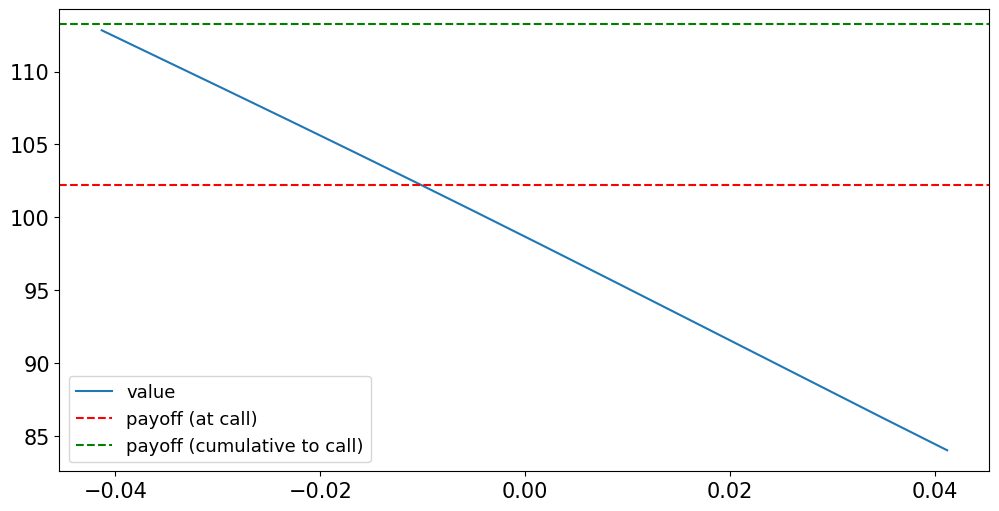

In [24]:
RECALC_IVOL = False

MAX_SHOCK = discs.loc[:Tmaturity,'spot rate'].min()
scenarios = pd.DataFrame(index=np.arange(-MAX_SHOCK, MAX_SHOCK, .0005), columns=['callable'],dtype=float)

for dr in scenarios.index:
    scenarios.loc[dr] = price_callable_bond(discs,ttm=T2,tte=T1,cpnrate=cpnrate,ivol=ivol_price,strike=K,accint=accint,face=100,recalculate_ivol=RECALC_IVOL,rateshock=dr)

num_cpns_Topt = np.ceil(Topt * cpnfreq)
cum_payoffs_Topt = clean_strike+coupon_payment*num_cpns_Topt

ax = scenarios[['callable']].plot()
ax.axhline(dirty_strike,color='red',linestyle='--')
ax.axhline(cum_payoffs_Topt,color='green',linestyle='--')
plt.legend(['value','payoff (at call)','payoff (cumulative to call)'])
plt.show()

### **<span style="color:red">1.9. Other Callable Bonds</span>**

At the top of the solution code, change `KEY_CALLABLE` to one of the other bonds to see analysis of the other callable bonds.

Consider changing the option expiration to see the effect of time-to-expiration.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

***

# **<span style="color:red">Solution 2</span>**

In [25]:
from ratecurves import *
from ficcvol import *

In [26]:
DATE = '2025-01-31'
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

### **<span style="color:red">2.1. </span>**

In using Black's formula for the caplet, be careful to use 
* $T-dt$ for the time-to-expiration, as the uncertainty of the floorlet is resolved one period early.
* the **forward vol** as a given caplet is priced correctly with forward vol.

In [27]:
N = 100
Tfloor = 3
isPayer=False
strikefloor = curves['swap rates'][Tfloor]
freqfloor = 4

fwdrate = curves.loc[Tfloor,'forwards']
fwdvol = curves.loc[Tfloor,'fwd vols']

Z = curves.loc[Tfloor,'discounts']

In [28]:
floorlet_value = N * (1/freqfloor) * blacks_formula(Tfloor-1/freqfloor,fwdvol,strikefloor,fwdrate,Z,isCall=isPayer)
display(f'Floorlet value at T={Tfloor} is ${floorlet_value:.4f}.')

'Floorlet value at T=3 is $0.1463.'

### **<span style="color:red">2.2. </span>**

We use the same procedure as pricing the individual floorlet, but for all floorlets in the floor. Two considerations:

1. There is no floorlet expiring at $T=0.25$.
1. The **flat vol** at $T=3$ can be used in every floorlet to price the overall floor. Equivalently can use the forward vol at the expiration of each floorlet.

In [29]:
maturities = np.arange(1/freqfloor,Tfloor+1/freqfloor,1/freqfloor)
floorlets = pd.DataFrame(index=maturities,columns=['price'])

for i,Tval in enumerate(floorlets.index):
    if i==0:
        floorlets.loc[Tval] = 0
    else:
        floorlets.loc[Tval] = N * (1/freqfloor) * blacks_formula(Tval-1/freqfloor,curves.loc[Tval,'fwd vols'],strikefloor,curves.loc[Tval,'forwards'],curves.loc[Tval,'discounts'],isCall=isPayer)                        

In [30]:
floorlets.style.format('${:.6f}').format_index('{:.2f}')

,price
0.25,$0.000000
0.50,$0.005783
0.75,$0.026128
1.00,$0.048403
1.25,$0.100422
1.50,$0.112247
1.75,$0.122743
2.00,$0.128122
2.25,$0.149285
2.50,$0.147793


In [31]:
floor = floorlets.sum().to_frame().rename(columns={0:'floor'})
floor.style.format('${:.4f}')

,floor
price,$1.1331


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

***

# **<span style="color:red">Solution 3</span>**

In [32]:
DATE = '2025-01-31'
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

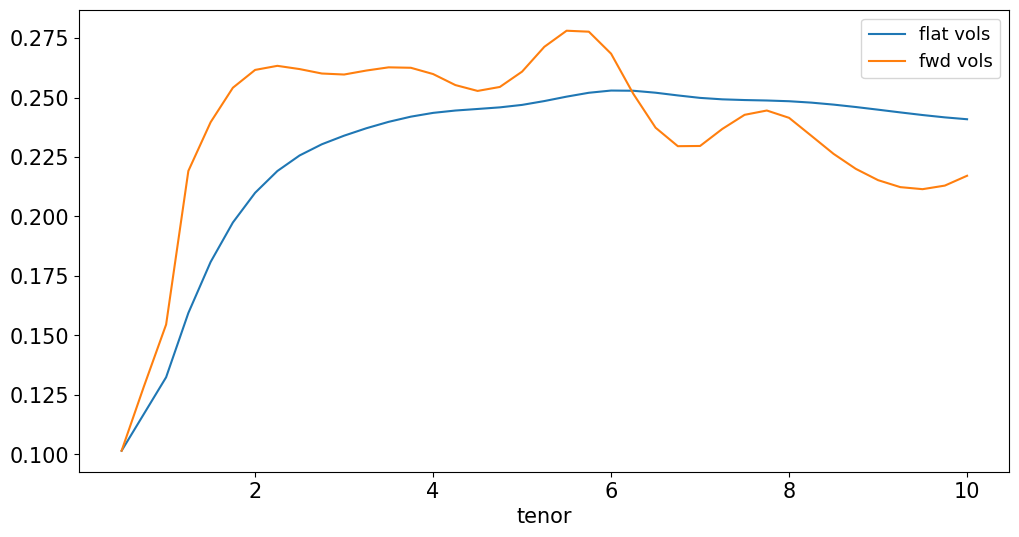

In [33]:
capcurves = flat_to_forward_vol(curves)

capcurves[['flat vols','fwd vols']].plot();